In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import rasterio 
from datetime import timedelta, date
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from numpy import isnan
from mord import LogisticAT
import pickle 
import matplotlib.pyplot as plt
import random

In [3]:
mean_2010 = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\NetCDF_Data\\annual_mean_2010.nc')
# max_2010 = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\ESA_SoilMoisture\\annual_maximum_2010.nc')
# min_2010 = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\ESA_SoilMoisture\\annual_minimum_2010.nc')
# mean_2016 = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\ESA_SoilMoisture\\annual_mean_2016.nc')
# max_2016 = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\ESA_SoilMoisture\\annual_maximum_2016.nc')
# min_2016 = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\ESA_SoilMoisture\\annual_minimum_2016.nc')

# sea_mean_2010 = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\ESA_SoilMoisture\\seasonal_mean_2010.nc')
# sea_max_2010 = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\ESA_SoilMoisture\\seasonal_maximum_2010.nc')
# sea_min_2010 = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\ESA_SoilMoisture\\seasonal_minimum_2010.nc')
# sea_mean_2016 = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\ESA_SoilMoisture\\seasonal_mean_2016.nc')
# sea_max_2016 = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\ESA_SoilMoisture\\seasonal_maximum_2016.nc')
# sea_min_2016 = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\ESA_SoilMoisture\\seasonal_minimum_2016.nc')

# sea_std_10 = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\ESA_SoilMoisture\\seasonal_std_2010.nc')
# sea_std_16 = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\ESA_SoilMoisture\\seasonal_std_2016.nc')
# ann_std_10 = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\ESA_SoilMoisture\\annual_std_2010.nc')
# ann_std_16 = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\ESA_SoilMoisture\\annual_std_2016.nc')

# HWSD_full = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\dosso_index\\HWSD_LCC_full_trimmed.nc')
# HWSD_noawc = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\dosso_index\\HWSD_LCC_fullna_trimmed.nc')
# SG_full = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\dosso_index\\SG_LCC_full_trimmed.nc')
# SG_noawc =  xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\dosso_index\\SG_LCC_fullna_trimmed.nc')

# HWSD_mod_awc = HWSD_noawc = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\dosso_index\\\HWSD_awcm_trimmed.nc')
# SG_mod_awc = xr.open_dataarray('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\dosso_index\\\SG_awcm_trimmed.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'C:\\Users\\Research\\Documents\\Tara_Fall_2019\\NetCDF_Data\\annual_mean_2010.nc'

In [26]:
# Aggregate SoilGrids AWC values (12.5m) out to resolution of Soil Moisture data (.25 degrees ~27.75 km) by taking the mean
# Then regress awc values on soil moisture at the lower resolution level to see if there is a relationship
# such large mismatch in the resolution of these data sets was messing with the optimization of the regression 

# pull data out 
x_data = sea_std_10
y_data = HWSD_mod_awc

# pull values and flatten into np arrays 
x_arr = x_data.values.flatten()
y_arr = y_data.values.flatten()
print (x_arr[:5], y_arr[:5])

# shift data by one so there are no zero values in the data 
x_arr_t = x_arr + 1
y_arr_t = y_arr + 1

# create nan mask so cells with missing data from either dataset are omitted
# WANT: only data cells where there is data in BOTH datasets
nan_mask = (~isnan(x_arr_t) * ~isnan(y_arr_t)).astype(int)

# multiply x and y values by mask to zero out cells where data is missing 
# note that none of the original data values are zero to avoid deleting actual data 
masked_x = nan_mask*x_arr_t
masked_y = nan_mask*y_arr_t

# drop data entries where one or both datasets have zero values or nan values
no_zero_x = masked_x[ masked_x != 0]
no_nan_x = no_zero_x[~np.isnan(no_zero_x)]
# go back and shift data back to original postion - divide by 100 because initial data was multiplied by 100 to preserve decimal points 
X_1 = (no_nan_x - 1)
    
no_zero_y = masked_y[ masked_y != 0]
no_nan_y = no_zero_y[~np.isnan(no_zero_y)]
Y_1 = (no_nan_y - 1)*100

[nan nan nan nan nan] [nan nan nan nan nan]


In [27]:
#NEXT: put X and Y values into tuple form in an np array so that we can group by unique values 
# WANT: Tuples of soil moisture and awc values 
tuple_arr = np.array((X_1,Y_1)).T
print(tuple_arr[:5])
# put tuples into a dataframe to use the groupby function
# group by unique values of soil moisture, take the mean of the awc values which have the same soil moisture value 
# this is analogous to averaing all awc values within a pixel of soil moisture data 
tuple_df = pd.DataFrame(tuple_arr).groupby(0, as_index = False).mean()
print (len(tuple_df))
# OR groupby standard deviation, comment one out! 
# tuple_df = pd.DataFrame(tuple_arr).groupby(0).std()
# tuple_df.reset_index(level=0, inplace=True)
# tuple_df = tuple_df.drop([13, 36])

print (tuple_df.head())
# pull out of the dataframe and back into np array
new_array = tuple_df.to_numpy()
# shuffle the data points before regressing 
random.shuffle(new_array)

# pull out X and Y values to use in regression, reshape to fit the function requirements
X = new_array.T[0].reshape(-1, 1)
Y = new_array.T[1].reshape(-1, 1)
print (X[:5], Y[:5])

[[23.99771309  8.23962688]
 [23.99771309  8.23962688]
 [23.99771309  8.23962688]
 [23.99771309  8.23962688]
 [23.99771309  8.23962688]]
61
           0          1
0  23.466482   8.239627
1  23.673210   8.239627
2  23.997713  11.027859
3  24.054897   8.307846
4  24.282957   8.239627
[[23.46648216]
 [23.46648216]
 [23.46648216]
 [23.46648216]
 [23.99771309]] [[ 8.23962688]
 [ 8.23962688]
 [ 8.23962688]
 [ 8.23962688]
 [11.02785912]]


Coefficients: 
 [[-0.09587471]]
Intercept: 
 [11.12769197]
Mean squared error: 19.79
Coefficient of determination: -0.25


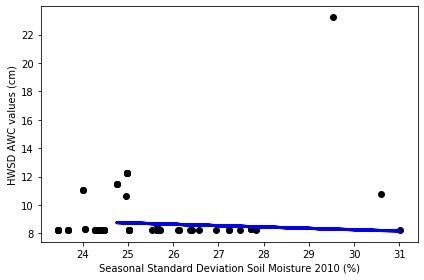

In [28]:
# build a regression an plot the data and the line of best fit 

#pull out train and test sets (80% train, 20% test)
train_x = X[:int(len(X)*.8)]
test_x = X[int(len(X)*.8):]
    
train_y = Y[:int(len(Y)*.8)]
test_y = Y[int(len(Y)*.8):]
    
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(train_x, train_y)

# Make predictions using the testing set of x values
y_pred = regr.predict(test_x)
    
# The coefficients
print('Coefficients: \n', regr.coef_)
    
# The intercept
print('Intercept: \n', regr.intercept_)
    
# The mean squared error
print('Mean squared error: %.2f'
    % mean_squared_error(test_y, y_pred))
    
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
    % r2_score(test_y, y_pred))

# Plot outputs  
fig, ax = plt.subplots()
ax.scatter(X, Y,  color='black')
ax.plot(test_x, y_pred, color='blue', linewidth=3)
# change these as neeeded! 
ax.set_ylabel('HWSD AWC values (cm)')
ax.set_xlabel('Seasonal Standard Deviation Soil Moisture 2010 (%)')
        
# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
fig = plt.gcf()
plt.show()

In [59]:
# want to save the figure? change the name of this path to the name of the figure you'd like to save 
path = "C:\\Users\\Research\\Documents\\Tara_Fall_2019\\figures\\HWSD_AWC_hist.png"
fig.savefig(path)

In [9]:
# input data is data arrays of x and y data - y = ax + b and a name for the pickled model
# Outcome is continuous here!!! 
def lin_regression_fxn(x_data, y_data, Pkl_Filename, path):
    
    # pull data, flatten into a 2d array with one column of data 
    x_arr = x_data.values.flatten().reshape(-1, 1)
    y_arr = y_data.values.flatten().reshape(-1, 1)
    
    # normalize data
#     scaler = MinMaxScaler(feature_range = (1,2))
#     x_arr_t = scaler.fit_transform(x_arr)
#     y_arr_t = scaler.fit_transform(y_arr)
    x_arr_t = x_arr + 1
    y_arr_t = y_arr + 1
    
    # create nan mask so cells with missing data from either dataset are omitted
    nan_mask = (~isnan(x_arr_t) * ~isnan(y_arr_t)).astype(int)
    
    # multiply x an y values by mask to zero out cells where data is missing 
    masked_x = nan_mask*x_arr_t
    masked_y = nan_mask*y_arr_t
    
    # drop data entries where one or both datasets have nan values
    no_zero_x = masked_x[ masked_x != 0]
    X = no_zero_x[~np.isnan(no_zero_x)].reshape(-1, 1)
    X = (X - 1)/100
    
    no_zero_y = masked_y[ masked_y != 0]
    Y = no_zero_y[~np.isnan(no_zero_y)].reshape(-1, 1)
    Y = (Y - 1)
    
    # split normalized, nonzero data into train and test sets - train = 80%, test = 20% 
#     train_x = X[:int(len(X)*.8)]
#     test_x = X[int(len(X)*.8):]
    
#     train_y = Y[:int(len(Y)*.8)]
#     test_y = Y[int(len(Y)*.8):]

    train_x = X[:int(len(X)*.8)][1::100]
    test_x = X[int(len(X)*.8):][1::100]
    
    train_y = Y[:int(len(Y)*.8)][1::100]
    test_y = Y[int(len(Y)*.8):][1::100]
    
    # Create linear regression object
#     regr = LinearRegression(fit_intercept = False)
    regr = LinearRegression()

    # Train the model using the training sets
    regr.fit(train_x, train_y)
#     with open(Pkl_Filename, 'wb') as file:  
#         pickle.dump(regr, file)

    # Make predictions using the testing set of x values
    y_pred = regr.predict(test_x)
    
    # The coefficients
    print('Coefficients: \n', regr.coef_)
    
    # The intercept
    print('Intercept: \n', regr.intercept_)
    
    # The mean squared error
    print('Mean squared error: %.2f'
          % mean_squared_error(test_y, y_pred))
    
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
          % r2_score(test_y, y_pred))

    # Plot outputs
    
    fig, ax = plt.subplots()

    # the histogram of the data
    ax.scatter(test_x, test_y,  color='black')
    ax.plot(test_x, y_pred, color='blue', linewidth=3)
    ax.set_ylabel('SoilGrids AWC (cm)')
    ax.set_xlabel('Annual Mean Soil Moisture 2016 (%)')
        
    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    fig = plt.gcf()
    fig.savefig(path)
    plt.show()
    

Coefficients: 
 [[0.00921373]]
Intercept: 
 [5.74937872]
Mean squared error: 3.04
Coefficient of determination: -1.85


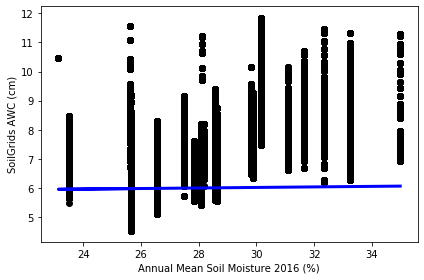

In [10]:
path = "C:\\Users\\Research\\Documents\\Tara_Fall_2019\\figures\\2016_mean_sm_v_SG_awc.png"
lin_regression_fxn(mean_2016, SG_mod_awc, "pickle", path)

In [87]:
# input data is data arrays of x and y data - y = ax + b and a name for the pickled file
# Outcome is ordered discrete data (USE THIS FOR LCC AS OUTCOME VARIABLE)
def ordlog_regression_fxn(x_data, y_data, Pkl_Filename, path):
    
    # pull data, flatten into a 2d array with one column of data 
    x_arr = x_data.values.flatten().reshape(-1, 1)
    y_arr = y_data.values.flatten().reshape(-1, 1)
    
    # normalize x data only
    scaler = MinMaxScaler(feature_range = (1,2))
    x_arr_t = scaler.fit_transform(x_arr)
    
    # create nan mask so cells with missing data from either dataset are omitted
    nan_mask = (~isnan(x_arr_t) * ~isnan(y_arr)).astype(int)
    
    # multiply x an y values by mask to zero out cells where data is missing 
    masked_x = nan_mask*x_arr_t
    masked_y = nan_mask*y_arr
    
    # drop data entries where one or both datasets have nan values
    no_zero_x = masked_x[ masked_x != 0]
    X = no_zero_x[~np.isnan(no_zero_x)].reshape(-1, 1)
    
    no_zero_y = masked_y[ masked_y != 0]
    Y = no_zero_y[~np.isnan(no_zero_y)].reshape(-1, 1)
    
    # split normalized, nonzero data into train and test sets - train = 80%, test = 20% 
    train_x = X[:int(len(X)*.8)]
    test_x = X[int(len(X)*.8):]
    
    train_y = Y[:int(len(Y)*.8)]
    test_y = Y[int(len(Y)*.8):]
    
    # Create ordinal logistic regression object
    model_ordinal = LogisticAT()
    
    # Train the model using the training sets
    model_ordinal.fit(train_x, train_y)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(model_ordinal, file)

    # Make predictions using the testing set of x values
    y_pred = model_ordinal.predict(test_x)
    
    # The coefficients
    print('Coefficients: \n', model_ordinal.coef_)
    
    # The mean squared error
    print('Mean squared error: %.2f'
          % mean_squared_error(test_y, y_pred))
    
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
          % r2_score(test_y, y_pred))

    # Plot outputs
    plt.scatter(test_x, test_y,  color='black')
    plt.plot(test_x, y_pred, color='blue', linewidth=3)

    plt.xticks(())
    plt.yticks(())
    plt.set_xlabel('Annual Mean Soil Moisture 2010 (%)')
    plt.set_ylabel('SoilGrids AWC (cm)')
    fig = plt.gcf()
    path = "C:\\Users\\Research\\Documents\\Tara_Fall_2019\\figures\\2010_mean_sm_v_SG_awc.png"
    fig.savefig(path)
    plt.show()